## Final Notebook

Please fill out:
* Group project 
* Student pace: self paced / part time / full time
* Scheduled project review date/time: 
* Instructor name: 
* Blog post URL:


## Finding least risk prone genres

### Importing necessary libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [2]:
import sqlite3
import zipfile

In [7]:
!ls zippedData

bom.movie_gross.csv.gz  rt.movie_info.tsv.gz    tn.movie_budgets.csv.gz
im.db                   rt.reviews.tsv.gz
im.db.zip               tmdb.movies.csv.gz


### Importing the data

In [3]:
# Extract IMDb SQL .db file
with zipfile.ZipFile('./zippedData/im.db.zip') as zipObj:
    # Extract all contents of .zip file into current directory
    zipObj.extractall(path='./zippedData/')
    
# Create connection to IMDb DB
con = sqlite3.connect('./zippedData/im.db')


IsADirectoryError: [Errno 21] Is a directory: 'zippedData/im.db'

In [ ]:
schema_df = pd.read_sql("""
        SELECT *
        FROM sqlite_master """, con)

In [ ]:
# Understanding the structure of the database
schema_df

In [ ]:
# Looking at movie_basics
pd.read_sql(""" 
            SELECT * 
            FROM movie_basics
            LIMIT 2
            """, con)

In [ ]:
# Looking at movie_ratings
pd.read_sql(""" 
            SELECT *
            FROM movie_ratings
            LIMIT 2
            """, con)

In [ ]:
# pulling movie_budgets csv
df_budget = pd.read_csv("zippedData/tn.movie_budgets.csv.gz")
df_budget.head()

### Joining data

In [ ]:
# inner joining movie_ratings and movie_basics in order to have access to ratings and genres in one table
df_combined = pd.read_sql(""" 
            SELECT *
            FROM movie_ratings
            JOIN movie_basics
            ON movie_basics.movie_id = movie_ratings.movie_id
            """, con)

In [ ]:
# Checking missing values
df_combined.info()

### Data cleaning

In [ ]:
# Dropping missing values in genres column
df_combined.dropna(subset = ['genres'], inplace = True)

In [ ]:
df_combined.head()

In [ ]:
# replacing $ and , characters in production_budget column
df_budget.production_budget = df_budget.production_budget.str.replace('$','').str.replace(',','')

# casting to integer so we can filter based on production budget 
df_budget.production_budget = df_budget.production_budget.astype(int)
df_budget.head(2)

In [ ]:
# slicing out high budget films in order to focus our analysis on high budget productions
df_high_budget = df_budget[df_budget.production_budget > 50000000]

In [ ]:
# There are 16 different movies with the same title but different release date
df_high_budget[df_high_budget.duplicated(subset = ['movie'], keep = False) == True].sort_values('movie')

In [ ]:
# Discovering that there are about 4 thousand of non unique titles in df_combined
len(df_combined.primary_title) - len(df_combined.primary_title.unique())

In [ ]:
#Creating column "title_year" in table df_combined: to use it to merge tables without unnecessary data loss
df_combined['title_year'] = df_combined.apply(lambda row: row.primary_title + " " + str(row.start_year), axis=1)

In [ ]:
df_combined.head(2)

In [ ]:
#Creating column "title_year" in table df_high_budget: to use it to merge tables without unnecessary data loss
df_high_budget['title_year'] = df_high_budget.apply(lambda row: row.movie + row.release_date[-5:], axis=1)

In [ ]:
#cleaning columns not needed from analysis
df_combined.drop(columns=['movie_id', 'original_title', 'primary_title', 'runtime_minutes', 'start_year'], axis=1, inplace = True)

In [ ]:
#cleaning columns not needed from analysis
df_high_budget.drop(columns=['id', 'release_date'], inplace = True)

In [ ]:
# Casting string type to title_year
df_combined.title_year = df_combined.title_year.astype(str)
df_high_budget.title_year = df_high_budget.title_year.astype(str)

In [ ]:
#Merging Budget and Combined tables to have access to all the data in one table
df_newdata = pd.merge(df_combined, df_high_budget, how = 'inner', on='title_year')

In [ ]:
df_newdata.head(2)

In [ ]:
#Filtering movies with the rating lower than median of the dataset. The analysis is focused on 
# the performance of low rating films.
low_ranking = df_newdata[df_newdata['averagerating'] < df_newdata['averagerating'].median()]

In [ ]:
#Eliminating films with low review count in order to focus on ratings substantiated by the review count.
low_ranking = low_ranking[low_ranking['numvotes'] > 1000]

In [ ]:
# Finding unique genres identifiers
genres_list = list(low_ranking.genres.unique())
newlst = []
for i in genres_list:
    
    newlst.extend(i.split(','))
unique_genres = list(set(newlst))
unique_genres

In [ ]:
#converting column genres into a list of genre identifiers
low_ranking['genres'] = low_ranking.apply(lambda row: row.genres.split(','), axis=1)

In [ ]:
#Exploding column with multiple genre identifiers into rows with single genre identifiers
low_ranking = low_ranking.explode('genres')

In [ ]:
low_ranking.count()

In [ ]:
#converting gross columns into integer datatype
low_ranking.domestic_gross = low_ranking.domestic_gross.str.replace('$','').str.replace(',','')
# replacing $ and , characters in production_budget column
low_ranking.worldwide_gross = low_ranking.worldwide_gross.str.replace('$','').str.replace(',','')

# casting to integer so we can filter based on production budget is 
low_ranking.domestic_gross = low_ranking.domestic_gross.astype(int)
low_ranking.worldwide_gross = low_ranking.worldwide_gross.astype(int)

In [ ]:
#Sanity check
low_ranking.head(2)

In [ ]:
# ROI is calculated by subtracting the beginning value from the current value 
# and then dividing the number by the beginning value.
# https://www.investopedia.com/terms/r/returnoninvestment.asp

low_ranking['roi'] = (low_ranking['worldwide_gross'] - low_ranking['production_budget'])/low_ranking['production_budget']


In [ ]:
# Creating profit column
low_ranking['profit'] = (low_ranking['worldwide_gross'] - low_ranking['production_budget'])

### Analysis and visualization

In [ ]:
# Romance stands out with negative correlation between rating and worldwide gross as well as ROI, and profit metrics.

In [ ]:
# Need to put them on 3 different scatterplots (ROI worldwide, Worldwide gross, Profit)
# and draw a regression line

# plt.savefig(‘/my_plot.png')

figure, (ax1, ax2, ax3) = plt.subplots(figsize=(15, 4), nrows=1, ncols=3, sharey = True)
scatter_plot_title = ['Romance']
ax1.scatter(x= 'averagerating', y= 'profit', data = low_ranking[low_ranking['genres'] == 'Romance'])
ax1.set_title([scatter_plot_title, low_ranking[low_ranking.genres=='Romance'].corr().loc['profit'][0].round(2)])
ax1.set_ylabel('PROFIT')
ax1.set_xlabel('RATING')

ax2.scatter(x= 'averagerating', y= 'worldwide_gross', data = low_ranking[low_ranking['genres'] == 'Romance'])
ax2.set_title([scatter_plot_title, low_ranking[low_ranking.genres=='Romance'].corr().loc['worldwide_gross'][0].round(2)])
ax2.set_ylabel('WORLDWIDE GROSS')
ax2.set_xlabel('RATING')

# ax3.scatter(x= 'averagerating', y= 'roi', data = low_ranking[low_ranking['genres'] == 'Romance'])
# ax3.set_title([scatter_plot_title, low_ranking[low_ranking.genres=='Romance'].corr().loc['roi'][0].round(2)])
# ax3.set_ylabel('ROI')
ax3.set_xlabel('RATING')

In [ ]:
low_ranking[low_ranking.genres=='Romance'].corr().loc['averagerating'].sort_values().round(2)
# .loc['profit'][0].round(2)

In [ ]:
low_ranking[low_ranking.genres=='Romance'].corr().loc['profit'][0].round(2)

In [ ]:
unique_genres

# Performance by budget tier

## Package imports

In [9]:
# Import standard packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sqlite3
import zipfile

%matplotlib inline

### Data Imports
* movie gross and production budget in 'tn.movie_budgets.csv.gz'

In [10]:
!ls zippedData

bom.movie_gross.csv.gz  rt.movie_info.tsv.gz    tn.movie_budgets.csv.gz
im.db                   rt.reviews.tsv.gz
im.db.zip               tmdb.movies.csv.gz


In [11]:
df_movie_budget = pd.read_csv("zippedData/tn.movie_budgets.csv.gz")
df_movie_budget.head()

,id,release_date,movie,production_budget,domestic_gross,worldwide_gross
0,1,"Dec 18, 2009",Avatar,"$425,000,000","$760,507,625","$2,776,345,279"
1,2,"May 20, 2011",Pirates of the Caribbean: On Stranger Tides,"$410,600,000","$241,063,875","$1,045,663,875"
2,3,"Jun 7, 2019",Dark Phoenix,"$350,000,000","$42,762,350","$149,762,350"
3,4,"May 1, 2015",Avengers: Age of Ultron,"$330,600,000","$459,005,868","$1,403,013,963"
4,5,"Dec 15, 2017",Star Wars Ep. VIII: The Last Jedi,"$317,000,000","$620,181,382","$1,316,721,747"


### Prepare the data for analysis

In [12]:
#Convert production_budget to an integer
df_movie_budget.production_budget = df_movie_budget.production_budget.str.replace('$','').str.replace(',','')
df_movie_budget.production_budget = df_movie_budget.production_budget.astype(int)

#Convert domestic_gross to an integer
df_movie_budget.domestic_gross = df_movie_budget.domestic_gross.str.replace('$','').str.replace(',','')
df_movie_budget.domestic_gross = df_movie_budget.domestic_gross.astype(int)

#Convert worldwide_gross to an integer
df_movie_budget.worldwide_gross = df_movie_budget.worldwide_gross.str.replace('$','').str.replace(',','')
df_movie_budget.worldwide_gross = df_movie_budget.worldwide_gross.astype(int)

In [13]:
#create a release year column
df_movie_budget["release_year"] = df_movie_budget["release_date"].str[-4:]
df_movie_budget.worldwide_gross = df_movie_budget.worldwide_gross.astype(int)

In [14]:
#Find the count of non-unique movie names
len(df_movie_budget)-len(df_movie_budget["movie"].unique())

84

In [15]:
#Create a more unique identifier for the film's name called title_and_year
df_movie_budget["title_and_year"] = df_movie_budget["movie"] + " (" + df_movie_budget["release_year"].astype(str)+")"

In [16]:
#Confirm that we have a more unique column of movie names in title_and_year
len(df_movie_budget)-len(df_movie_budget["title_and_year"].unique())

1

In [17]:
#Range of years in our data
df_movie_budget["release_year"].astype(int).max() - df_movie_budget["release_year"].astype(int).min() 

105

In [18]:
#We have some old movies in our data but the lare majority of the films were produced int he past 20 years
df_movie_budget["release_year"].astype(int).describe()

count    5782.000000
mean     2003.967139
std        12.724386
min      1915.000000
25%      2000.000000
50%      2007.000000
75%      2012.000000
max      2020.000000
Name: release_year, dtype: float64

In [19]:
#Add an ROI and profit column
df_movie_budget["profit"] = df_movie_budget["worldwide_gross"]-df_movie_budget["production_budget"]
df_movie_budget["ROI"] = df_movie_budget["profit"]/df_movie_budget["production_budget"]

#### Bucket budgets into tiers and remove irrelevant tiers

Screen Actors Guild project budgets https://www.sagaftra.org/production-center/contract/813/getting-started

In [20]:
#budget ranges from SAG
student_film = range(0,34999)
short_project = range(35000,49999)
ultra_low_budget = range(50000,299999)
moderate_low_budget = range(300000,699999)
low_budget_theatrical = range(700000,1999999)
threatrical_budget = range(2000000,150000000)
#blockbuster  150,000,000 and 400,000

In [21]:
#create a function that takes in a budget and returns the budget tier
def find_budget(x):
    if x in student_film:
        return("student_film")
    elif x in short_project:
        return("short_project")
    elif x in ultra_low_budget:
        return("ultra_low_budget")
    elif x in moderate_low_budget:
        return("moderate_low_budget")
    elif x in low_budget_theatrical:
        return("low_budget_theatrical")
    elif x in threatrical_budget:
        return("threatrical_budget")
    elif x >= 150000000:
        return("blockbuster")
    else:
        return("N/A")

In [22]:
#create a new column that includes the budget tier
df_movie_budget["budget_tier"] = df_movie_budget["production_budget"].map(find_budget)

In [23]:
#Remove scientific notation round up to the nearest integer
pd.options.display.float_format = '{:.0f}'.format
df_movie_budget.groupby('budget_tier').mean().sort_values("production_budget")

,id,production_budget,domestic_gross,worldwide_gross,profit,ROI
budget_tier,,,,,,
student_film,60,17104,1247342,1289271,1272167,63
short_project,32,39400,87020,97172,57772,2
ultra_low_budget,52,166012,1915045,3231987,3065974,22
moderate_low_budget,45,459071,4033616,6282674,5823603,12
low_budget_theatrical,50,1208675,5207438,8093388,6884713,6
threatrical_budget,51,30200583,40565626,83260216,53059633,2
blockbuster,49,189298462,225876251,635843904,446545443,2


In [24]:
#we will drop the student_film and short_project rows because Mircrosoft is not interested in such small investments despite their high ROI because the profit isn't worth their time
df_movie_budget_cleaned = df_movie_budget[df_movie_budget["budget_tier"].str.contains("student_film|short_project") == False]

#### Examine the tendancies of ROI data & adjust for risk
* Lower budget films have enormous standard deviation of their ROIs
* This standard devation can be thought of as risk, so lower budget films are riskier
* To control for for the risk of the investment, we will be creating a new column called adjusted_risk that used an adjusted Sharpe Ratio*

* *https://www.investopedia.com/terms/s/sharperatio.asp

In [25]:
#Investigate the data tendancies of gross 
df_movie_budget_cleaned.groupby('budget_tier')["worldwide_gross"].describe().sort_values("budget_tier")

,count,mean,std,min,25%,50%,75%,max
budget_tier,,,,,,,,
blockbuster,195,635843904,407603051,0,346953224,554606532,814232157,2776345279
low_budget_theatrical,395,8093388,24927738,0,12720,839145,5479640,268000000
moderate_low_budget,170,6282674,26032754,0,0,85016,2028547,248300000
threatrical_budget,4806,83260216,129092641,0,9206662,35579092,101082961,1341693157
ultra_low_budget,160,3231987,9975372,0,0,33262,2025695,99750000


In [26]:
#Lower budget films have enormous standard deviation of their ROIs
df_movie_budget_cleaned.groupby('budget_tier')["ROI"].describe().sort_values("budget_tier")

,count,mean,std,min,25%,50%,75%,max
budget_tier,,,,,,,,
blockbuster,195,2,2,-1,1,2,3,10
low_budget_theatrical,395,6,25,-1,-1,-0,4,311
moderate_low_budget,170,12,51,-1,-1,-1,4,431
threatrical_budget,4806,2,6,-1,-0,1,3,99
ultra_low_budget,160,22,68,-1,-1,-1,9,498


In [27]:
#Create a dictionary sharpe_ratio_adjuster to assit in adjusting our ROI column
ROI_std_values = list(df_movie_budget_cleaned.groupby('budget_tier').std().sort_values("production_budget")["ROI"].values)
ROI_std_keys = list(df_movie_budget_cleaned.groupby('budget_tier').std().sort_values("production_budget")["ROI"].index)
sharpe_ratio_adjuster = dict(zip(ROI_std_keys,ROI_std_values))
sharpe_ratio_adjuster

{'ultra_low_budget': 67.77891102442578,
 'moderate_low_budget': 51.36547115598832,
 'low_budget_theatrical': 25.20094233428327,
 'threatrical_budget': 5.538579427591486,
 'blockbuster': 1.8020358642041443}

In [28]:
#create a new column called adjusted_ROI
df_movie_budget_cleaned["adjusted_ROI"] = df_movie_budget_cleaned["ROI"] / df_movie_budget_cleaned["budget_tier"].map(sharpe_ratio_adjuster)

<ipython-input-28-52d23e069a46>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_movie_budget_cleaned["adjusted_ROI"] = df_movie_budget_cleaned["ROI"] / df_movie_budget_cleaned["budget_tier"].map(sharpe_ratio_adjuster)


#### Examine relationship between budget tier & profitability

* There is strong positive correlation between size of the budget tier and total profit of the film <br>
* There is a negative correlation between size of the budget tier and ROI of the film<br>
* However, when we look at the relationship between budget tier and Adjusted ROI, the correlation flips and it's clear that the highest budget tiers produce the largest risk Adjusted ROI.
* This suggests that when you want to make a lot of money from a single film and you want to avoid risk, the best strategy is to invest in a blockbuster. When you consider the demands of filling out a streaming service with content, it becomes neccesary to invest in other less expensive budget tiers. The best way to fill out the content library is with but given the flexibility to invest in multiple films, spreading your budget out to multiple less-expensive films is more profitable.

<ipython-input-41-48991e602106>:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_yticklabels(['${:,.0f}'.format(x) for x in current_values]);


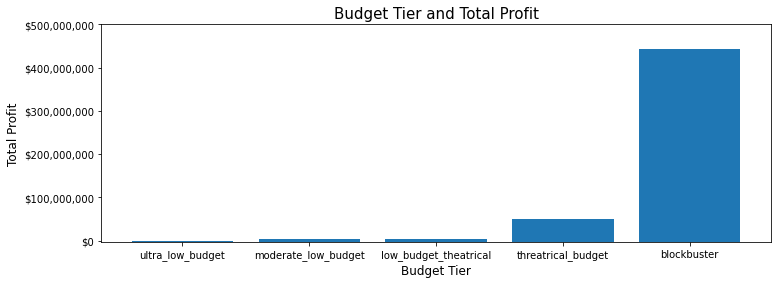

In [41]:
#Plotting profit by budget tier
y = df_movie_budget_cleaned.groupby('budget_tier').mean().sort_values("production_budget")["profit"]
x = list(df_movie_budget_cleaned.groupby('budget_tier').mean().sort_values("production_budget")["profit"].index)
fig, ax = plt.subplots(figsize=(12, 4))
ax.bar(x,y)
#remove scientific notation
plt.gcf().axes[0].yaxis.get_major_formatter().set_scientific(False)
#change yaxes number format
current_values = plt.gca().get_yticks()
plt.gca().set_yticklabels(['${:,.0f}'.format(x) for x in current_values]);
#add chart and axes titles
ax.set_title("Budget Tier and Total Profit",fontsize=15)
ax.set_ylabel("Total Profit",fontsize=12)
ax.set_xlabel("Budget Tier",fontsize=12);
#adjust y axes ticks
plt.yticks(np.arange(min(y), 600000000, 100000000));

<ipython-input-42-7856b548c8d6>:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_yticklabels(['{:,.0f}'.format(x) for x in current_values]);


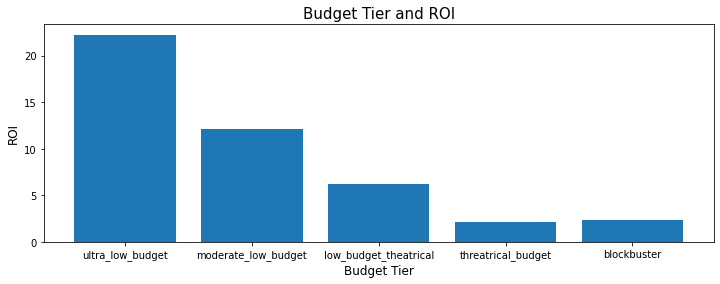

In [42]:
#Plotting ROI by budget tier
y = df_movie_budget_cleaned.groupby('budget_tier').mean().sort_values("production_budget")["ROI"]
x = list(df_movie_budget_cleaned.groupby('budget_tier').mean().sort_values("production_budget")["ROI"].index)
fig, ax = plt.subplots(figsize=(12, 4))
ax.bar(x,y)
#remove scientific notation
plt.gcf().axes[0].yaxis.get_major_formatter().set_scientific(False)
#change yaxes number format
current_values = plt.gca().get_yticks()
plt.gca().set_yticklabels(['{:,.0f}'.format(x) for x in current_values]);
#add chart and axes titles
ax.set_title("Budget Tier and ROI",fontsize=15)
ax.set_ylabel("ROI",fontsize=12)
ax.set_xlabel("Budget Tier",fontsize=12);
#adjust y axes ticks
plt.yticks(np.arange(0, max(y)+2, 5));

In [56]:
!ls

Alex-working-document.ipynb final_notebook.ipynb
CONTRIBUTING.md             movie_data_erd.jpeg
LICENSE.md                  student-Copy1.ipynb
README.md                   student.ipynb
awesome.gif                 visualization_images
data                        zippedData


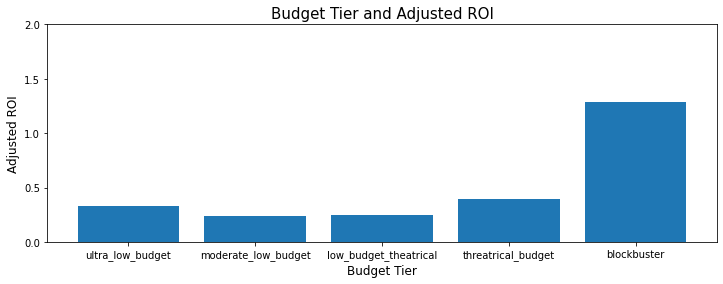

In [60]:
#Plotting adjusted ROI by budget tier
y = df_movie_budget_cleaned.groupby('budget_tier').mean().sort_values("production_budget")["adjusted_ROI"]
x = list(df_movie_budget_cleaned.groupby('budget_tier').mean().sort_values("production_budget")["adjusted_ROI"].index)
fig, ax = plt.subplots(figsize=(12, 4))
ax.bar(x,y)
#remove scientific notation
plt.gcf().axes[0].yaxis.get_major_formatter().set_scientific(False)
#add chart and axes titles
ax.set_title("Budget Tier and Adjusted ROI",fontsize=15)
ax.set_ylabel("Adjusted ROI",fontsize=12)
ax.set_xlabel("Budget Tier",fontsize=12);
#adjust y axes ticks
plt.yticks(np.arange(0, max(y)+1, .5))
#save figure to visualization_images folder
plt.savefig("visualization_images/Budget_Tier_and_Adjusted_ROI");

### Budget allocation

#### Assumptions
* Assume a budget of 5B movie budget (Netflix spends 17B toatl, HBO spends 18B total)
https://www.indiewire.com/2022/03/streaming-wars-content-spend-disney-netflix-hbo-paramount-1234703867/

* Assume Microsoft needs to produce 100 new titles per year to keep up with Netflix's 153 new movie titles in 2021
https://en.wikipedia.org/wiki/List_of_Netflix_original_films_(2021)

#### Recommendations
* Microsoft should allocate 94% of budget to Blockbusters because they generate the best risk adjusted ROI
* To fulfill the required 100 films, use .21% of the budget producing 65 Ultra Low Budget films. These have the benefit of being incredibly cheap and stand a chance of far outperfoming their budget
* The safe bet to fulfil the remaining 10 film requirement is to invest in Theatrical budget films which have a solid risk adjusted ROI and are less expensive than Blockbusters
Allocate (x) to moderate_low_budget and low_budget_theatrical because they produce high ROIm

In [33]:
budget_allocation_table = {'Budget_tier': ['Blockbuster', 'Theatrical_budget','Ultra_low_budget'],
                           'Films':  [25,10,65],
                           'Production_cost': [4732461550,302005830,10790780],
                           'Budget_allocation_%': [.938,.060,.002]}
pd.DataFrame(budget_allocation_table)

,Budget_tier,Films,Production_cost,Budget_allocation_%
0,Blockbuster,25,4732461550,1
1,Theatrical_budget,10,302005830,0
2,Ultra_low_budget,65,10790780,0


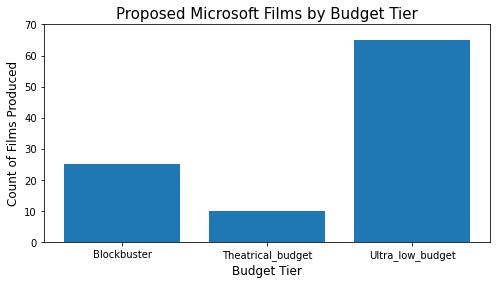

In [69]:
#Plotting proposed films production by budget tier

y = budget_allocation_table['Films']
x = budget_allocation_table['Budget_tier']

fig, ax = plt.subplots(figsize=(8, 4))
ax.bar(x,y)

#add chart and axes titles
ax.set_title("Proposed Microsoft Films by Budget Tier",fontsize=15)
ax.set_ylabel("Count of Films Produced",fontsize=12)
ax.set_xlabel("Budget Tier",fontsize=12);
#adjust y axes ticks
plt.yticks(np.arange(0, 80, 10))
#save figure to visualization_images folder
plt.savefig("visualization_images/Proposed_Microsoft_Films_by_Budget_Tier");

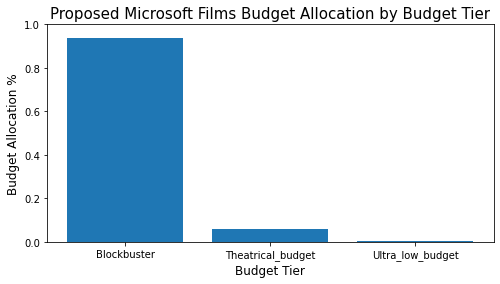

In [67]:
#Plotting proposed budget allocation by budget tier

y = budget_allocation_table['Budget_allocation_%']
x = budget_allocation_table['Budget_tier']

fig, ax = plt.subplots(figsize=(8, 4))
ax.bar(x,y)
#remove scientific notation
plt.gcf().axes[0].yaxis.get_major_formatter().set_scientific(False)

#add chart and axes titles
ax.set_title("Proposed Microsoft Films Budget Allocation by Budget Tier",fontsize=15)
ax.set_ylabel("Budget Allocation %",fontsize=12)
ax.set_xlabel("Budget Tier",fontsize=12);
#adjust y axes ticks
plt.yticks(np.arange(0, 1.1, .2))
#save figure to visualization_images folder
plt.savefig("visualization_images/Proposed_Microsoft_Films_Budget_Allocation_by_Budget_Tier");